# Code example with simulated data

In the following code section a data sample is generated from a theoretical data generating process (DGP). One of the time series $y_0$ is a linear combination of a subset of the other time series.The rest of the time series will be correlated with their own past values only. All other linear relations between variables are approximately equal to zero. Only lines of code relevant to the use of the package are displayed, other dependencies of the example are imported from 'example_data.py'.


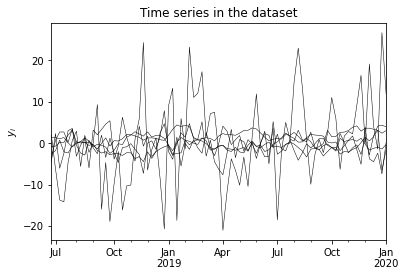

In [1]:
import example_data
import matplotlib.pyplot as plt
%matplotlib inline
in_sample, out_sample, phis, betas, ar1_names = example_data.simulate_data(random_seed=22011995)
example_data.plot_part_of_sample(in_sample)

# Comparing Ridge to pure least squares

Now we want to compare how a purely MLS fitted model compares to the Ridge penalized alternative. First, in both the MLS and the Ridge case the data is standardized. For the MLS case but it makes comparison more exact in a numerical sense.

$$x = (x - \mu_x)/\sigma_x$$


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(in_sample)
in_sample_transformed = in_sample.copy()
in_sample_transformed.iloc[:, :] = scaler.transform(in_sample)
scales_df = pd.DataFrame(data=scaler.scale_, index=in_sample.columns, columns=['scale_original'])

Now that we standardized the data, we can evaluate which models rescaled parameter estimates most closely match the real parameters used in our simulation. It is easily shown that we can rescale the parameter estimates that we obtain from the standardized data to be comparable to the parameters of a linear model on the levels (untransformed) data.

In the code section below we fit the first model using MLS. Then we find an optimal value for the ridge penalty $\lambda^*$ by minimizing the variable part of $AIC$ $(\Delta AIC)$ for models with various values of $\lambda_i$. And finally we fit a model with our estimated optimal amount of regularization. The plots show $\Delta AIC$ versus $\lambda_i$ and the final parameter estimates versus the actual parameter values for both models.

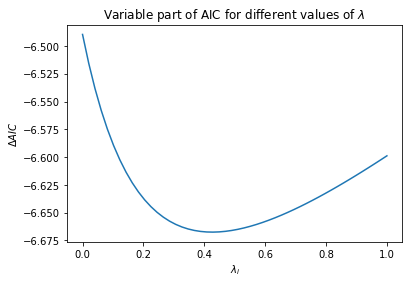

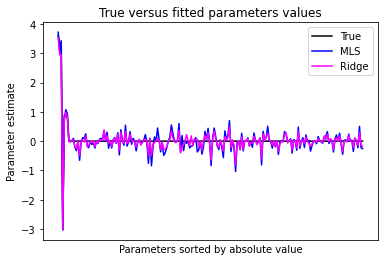

In [3]:
# We specify the pure MLS model
# In a real world scenario we would not know which lag-order to use so we would start by including as many as is feasible given
# the legth of the sample

from ridge_varx import RidgeVARX
import numpy as np

df_endog = in_sample_transformed.drop(columns=['unrelated_exogenous', 'related_exogenous'])
df_exog = in_sample_transformed[['unrelated_exogenous', 'related_exogenous']]

# fit the MLS model
modfit_MLS = RidgeVARX(endog=df_endog,
                exog=df_exog)\
                .fit(lags=12, deterministic_terms=None)

# find a good value for lambda
opt_ridge_penalty = example_data.plot_ridge_grid(mod=RidgeVARX(endog=df_endog,
                exog=df_exog),fit_kwargs=dict(lags=12,standardize=False,
                            deterministic_terms=None),ridge_grid=np.linspace(1e-6, 1, 50))


# Fit the ridge model
modfit_Ridge = RidgeVARX(endog=df_endog,
                exog=df_exog)\
                        .fit(lags=12,
                        ridge_penalty=opt_ridge_penalty,
                        standardize=False,
                            deterministic_terms=None) # the default behavior is to standardize the data but we did that already

# plot the two sets of parameter estimates against the actual parameter values
rescaled_MLS = example_data.rescale_params(scales_df, modfit_MLS.params)
rescaled_Ridge = example_data.rescale_params(scales_df, modfit_Ridge.params)

example_data.plot_true_vs_fit(rescaled_MLS, rescaled_Ridge, betas, phis, ar1_names)

## p-Values for the estimated parameters

Under the assumption of correct dynamic model specification, that is $u_i \perp u_{j} \forall i \neq j$, meaning that the error terms of each modelled time series are not autocorrelated. The package can produce valid p-values regardless of whether ridge regularization was used. 

This way, important predictors can be identified out of many stationary time series.


If Ridge regularization was used, the p-values are corrected to be based on the theoretical variance of the ridge parameter estimates. Remember that in this case we test whether the estimated ridge parameters are significantly different from zero. Which is different from testing whether the true population parameters are significantly different from zero. It does however tell us which variables are important predictors in the regularized model.

In [4]:
modfit_Ridge.p_vals

,y1_explanatory_lag1,y2_explanatory_lag1,y3_explanatory_lag1,y0_explanatory_lag1,y1_explanatory_lag2,y2_explanatory_lag2,y3_explanatory_lag2,y0_explanatory_lag2,y1_explanatory_lag3,y2_explanatory_lag3,...,y1_explanatory_lag11,y2_explanatory_lag11,y3_explanatory_lag11,y0_explanatory_lag11,y1_explanatory_lag12,y2_explanatory_lag12,y3_explanatory_lag12,y0_explanatory_lag12,unrelated_exogenous,related_exogenous
predict_y1,0.000009,2.006403e-01,2.452136e-01,0.244120,0.371456,0.390914,0.321485,0.375772,0.327925,0.017245,...,0.251155,0.001554,0.382766,0.386936,0.062445,0.300915,0.095492,0.215947,0.463945,0.165792
predict_y2,0.113139,4.966575e-09,3.805341e-01,0.262001,0.360757,0.089188,0.468845,0.257945,0.046434,0.392092,...,0.469445,0.344452,0.297150,0.484426,0.471455,0.444109,0.311456,0.155468,0.256942,0.323628
predict_y3,0.060582,6.452844e-02,7.496553e-08,0.015576,0.012532,0.168321,0.318444,0.162105,0.126587,0.425622,...,0.417438,0.163525,0.191481,0.214228,0.383017,0.469178,0.117722,0.319591,0.074532,0.256944
predict_y0,0.000000,5.243956e-02,2.825347e-01,0.287367,0.289104,0.000000,0.206086,0.462709,0.267336,0.285503,...,0.111000,0.195338,0.220811,0.257199,0.450253,0.127913,0.311182,0.261149,0.232917,0.000000


## Forecast using endogenous and exogenous variables

Dynamic forecasts of any length h can be produced using the forecast method. In this case have to provide out of sample values of the exogenous variables because we are not forecasting the exogenous variables. In the example below we produce a 52-week fixed horizon forecast using both models. The out of sample MSE is displayed together with the forecasts. In this example the Ridge model performs better out of sample.

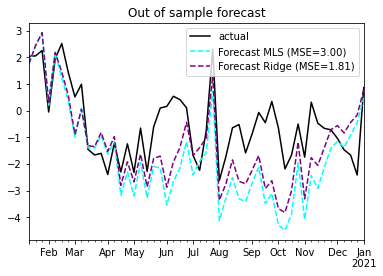

In [5]:
# We fitted the model on transformed data and will therefore have to transform the oou of sample exogenous variables too
out_sample_transformed = out_sample.copy()
out_sample_transformed.iloc[:, :] = scaler.transform(out_sample)
n_out_of_sample = len(out_sample_transformed)

# forecasts of any length can be produced using either model.
# if there are exogenous variables in the model, future values need to be supplied
forecast_MLS = modfit_MLS.forecast(h=n_out_of_sample, exog_future=out_sample_transformed[['unrelated_exogenous', 'related_exogenous']])
forecast_Ridge = modfit_Ridge.forecast(h=n_out_of_sample, exog_future=out_sample_transformed[['unrelated_exogenous', 'related_exogenous']])

example_data.plot_out_of_sample(forecast_MLS, forecast_Ridge, out_sample_transformed)